# Фильтр частиц

Рассмотрим движение мобильного робота, двигающегося в одном направлении, перпендикулярно стене. Робот передвигается на заданную дистанцию с погрешностью 2.

$$
x_{k+1} = x_k + u_{k+1} +\xi
$$

Робот измеряет свое положение с погрешностью 3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

sigma_pos = 2
sigma_meas = 3

robotX = 20 + np.random.normal(0, sigma_pos)

def movement(x, u):
    return x + u + np.random.normal(0, sigma_pos)

robotX
    

20.503180956249853

Зададим функцию измерения

In [2]:
def measurement(x):
    return x + np.random.normal(0, sigma_meas)

Зададим последовательность управляющих команд робота

In [3]:
u = [5, 10, 3, -7, 6, -10]

Промоделируем движение робота

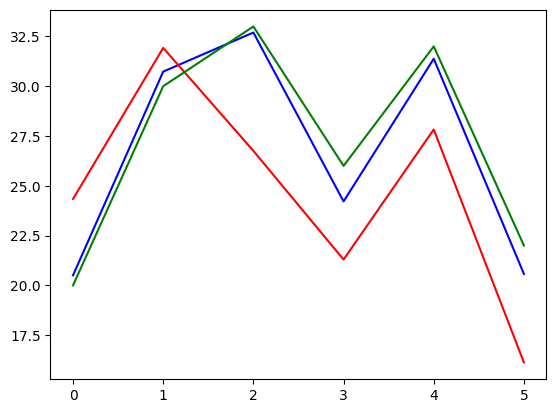

In [4]:
X = [robotX]
Y = [measurement(robotX)]

T = [0]

x_ideal = 20
X_ideal = [x_ideal]

for k in range(1, len(u)):
    T.append(k)
    robotX = movement(robotX, u[k])
    X.append(robotX)
    robotMeas = measurement(robotX)
    Y.append(robotMeas)
    x_ideal = x_ideal + u[k]
    
    
    X_ideal.append(x_ideal)
    
plt.plot(T, X, c='b')
plt.plot(T, Y, c='r')
plt.plot(T, X_ideal, c='g')
plt.show()    

Создадим частицы - копии объекта со случайным начальным положением

In [5]:
N_particles = 1000
particles = np.zeros(N_particles)

for i in range(N_particles):
    particles[i] = 20 + np.random.normal(sigma_pos)

Зададим веса частиц

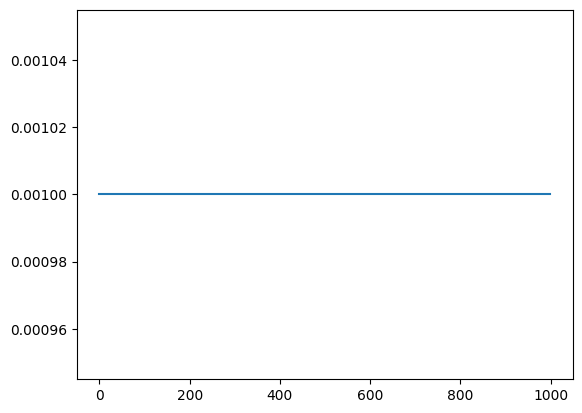

In [6]:
weights = np.ones(N_particles) / N_particles

plt.plot(range(N_particles), weights)

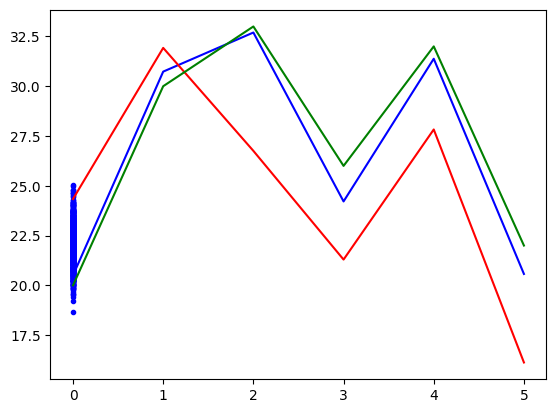

In [7]:
plt.plot(T, X, c='b')
plt.plot(T, Y, c='r')
plt.plot(T, X_ideal, c='g')
plt.scatter(np.zeros(N_particles), particles, c='b', marker='.')
plt.show()    

In [8]:
def move_particles(particles, u):
    new_particles = []
    for particle in particles:
        new_particles.append(particle + u)
    return new_particles

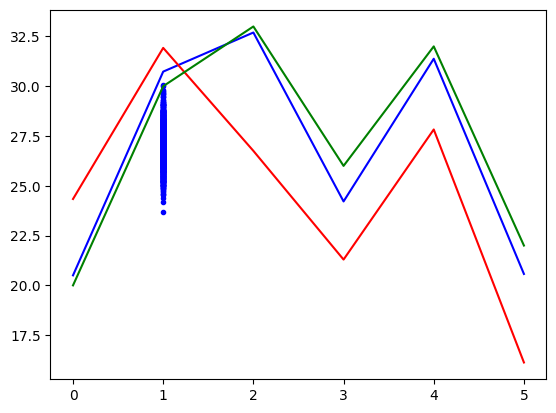

In [9]:
new_particles = move_particles(particles, u[0])

plt.plot(T, X, c='b')
plt.plot(T, Y, c='r')
plt.plot(T, X_ideal, c='g')
plt.scatter(np.ones(N_particles), new_particles, c='b', marker='.')
plt.show()    

Построим функцию для рассчета вероятности получения измерений для каждой частицы

In [10]:
def prob(dist, meas_dist):
    return 1/np.sqrt(2 * np.pi * sigma_meas) * np.exp( -(dist - meas_dist)**2 / sigma_meas )

Построим функцию, которая перераспределяет веса в соответствии с вероятностью

In [11]:
def weight_calc(particles, weights, robot_measurement):
    for i in range(N_particles):
        weights[i] = prob(particles[i], robot_measurement)
    weights = weights / np.sum(weights)

    return weights

<BarContainer object of 1000 artists>

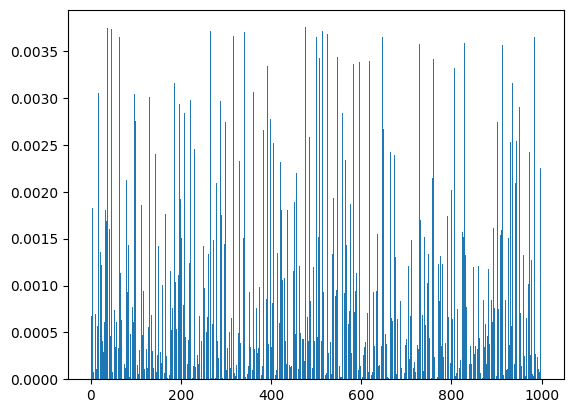

In [12]:
new_weights = weight_calc(particles, weights, Y[0])

plt.bar(range(N_particles), new_weights)

Отсев

In [13]:
def resample(particles, weights):
    newParticles = []
    newWeights = []
    N = len(particles)
    index = np.random.randint(0, N)
    betta = 0
    for i in range(N):
        betta = betta + np.random.uniform(0, 2*max(weights))
        while betta > weights[index]:
            betta = betta - weights[index]
            index = (index + 1)%N # индекс изменяется в цикле от 0 до N
        newParticles.append(particles[index])
        newWeights.append(weights[index])
    newWeights = newWeights / np.sum(newWeights)
    
    return np.array(newParticles), newWeights

Оценка положения

In [14]:
def estimation(particles, weights):
    estimateX = 0
    for i in range(len(particles)):
        estimateX = estimateX + particles[i] * weights[i]
    return estimateX

Все вместе

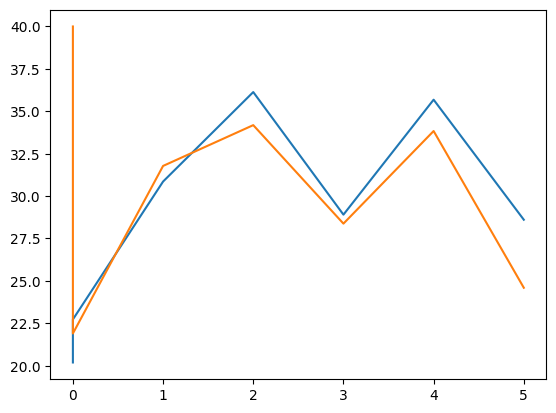

In [15]:
sigma_pos = 2
sigma_meas = 3

robotX = 20 + np.random.normal(0, sigma_pos)




N_particles = 2000
particles = np.zeros(N_particles)

for i in range(N_particles):
    particles[i] = robotMeas + np.random.normal(sigma_meas)


weights = np.ones(N_particles) / N_particles


robotMeas = estimation(particles, weights)

movement_list = u

X = [robotX]
Y = [robotMeas]
X_est = [40]
T= [0]

for step in range(len(movement_list)):
    robotX = movement(robotX, movement_list[step])
    X.append(robotX)
    T.append(step)
    
    robotMeas = measurement(robotX)
    Y.append(robotMeas)
    
    particles = move_particles(particles, movement_list[step])
    
    weights = weight_calc(particles, weights, robotMeas)

    particles, weights = resample(particles, weights)

    estX = estimation(particles, weights)
    X_est.append(estX)
    

plt.plot(T, X)
plt.plot(T, X_est)
plt.show()

Вероятностная робототехника 115 - модели движения